In [1]:
import numpy as np
import xarray as xr
import os.path as op
import dask.array as dsar
from dask.diagnostics import ProgressBar
from scipy.io import loadmat
from scipy.interpolate import PchipInterpolator as pchip
from xmitgcm import open_mdsdataset
from xgcm.grid import Grid
import xrft
from matplotlib.colors import SymLogNorm
from matplotlib import colors
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
bdir = '/swot/SUM02/takaya/channelMOC-Darwin/'
pdir = '/swot/SUM05/takaya/MITgcm/channel/runs/'

In [3]:
mon = xr.open_dataset(op.join(bdir,'monitor.0000000000.t001.nc'))
mon

FileNotFoundError: [Errno 2] No such file or directory: b'/swot/SUM02/takaya/channelMOC-Darwin/monitor.0000000000.t001.nc'

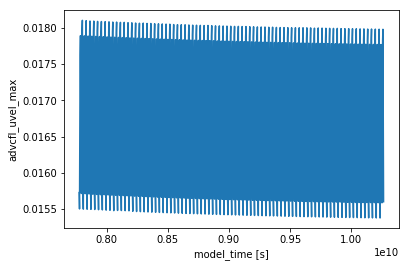

In [98]:
mon.advcfl_uvel_max.plot()

In [88]:
dt = 4.8e3
ys,dy = (1095,5) # 330 yrs of spin up
ts = int(ys*360*86400/dt)
te = int(ts+dy*360*86400/dt)
print(ts,te)

7095600 7128000


In [89]:
dsave = open_mdsdataset(op.join(bdir,'100kmMLI_GMR4000'), 
                       grid_dir=op.join(bdir,'100km_grid'), 
                       iters=range(ts+540,te+540,540),
#                        iters=range(int(360*86400*ys/8e2 + 0e0*360*86400/12e2 + 112e0*360*86400/36e2 
#                                       + 177*360*86400/dt)+1440,
#                                   int(360*86400*ys/8e2 + 0e0*360*86400/12e2 + 112e0*360*86400/36e2 
#                                      + 177*360*86400/dt+360*86400*17/dt)+1440,1440),
                       prefix=['Ttave',
#                               'uVeltave',
#                                'wVeltave',
                              'PTRtave03',
                              'SF30D'
#                               ,'PtrFlux03'
                              ], delta_t=dt
                      )
dsave

/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)


<xarray.Dataset>
Dimensions:    (XC: 10, XG: 10, YC: 20, YG: 20, Z: 40, Zl: 40, Zp1: 41, Zu: 40, time: 60)
Coordinates:
  * XC         (XC) >f4 50000.0 150000.0 250000.0 ... 750000.0 850000.0 950000.0
  * YC         (YC) >f4 50000.0 150000.0 250000.0 ... 1850000.0 1950000.0
  * XG         (XG) >f4 0.0 100000.0 200000.0 ... 700000.0 800000.0 900000.0
  * YG         (YG) >f4 0.0 100000.0 200000.0 ... 1700000.0 1800000.0 1900000.0
  * Z          (Z) >f4 -5.0 -15.0 -25.0 -36.0 ... -2727.5 -2830.5 -2933.5
  * Zp1        (Zp1) >f4 0.0 -10.0 -20.0 -30.0 ... -2779.0 -2882.0 -2985.0
  * Zu         (Zu) >f4 -10.0 -20.0 -30.0 -42.0 ... -2779.0 -2882.0 -2985.0
  * Zl         (Zl) >f4 0.0 -10.0 -20.0 -30.0 ... -2676.0 -2779.0 -2882.0
    rA         (YC, XC) >f4 dask.array<shape=(20, 10), chunksize=(20, 10)>
    dxG        (YG, XC) >f4 dask.array<shape=(20, 10), chunksize=(20, 10)>
    dyG        (YC, XG) >f4 dask.array<shape=(20, 10), chunksize=(20, 10)>
    Depth      (YC, XC) >f4 dask.array<shape

In [54]:
grid = Grid(dsave, periodic=['X'])
f0 = -1.1e-4
beta = 1.4e-11
g = 9.81
r0 = 1e3
alpha = 2e-4

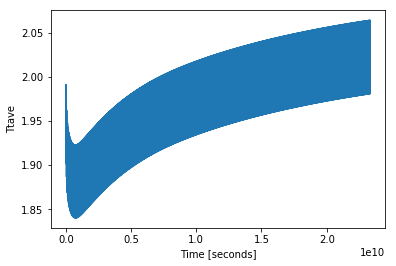

In [40]:
(dsave.Ttave).mean(['Z','YC','XC']).plot()

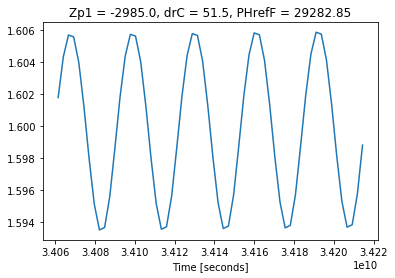

In [90]:
(dsave.Ttave*dsave.drF*np.abs(dsave.Zp1[-1])**-1).sum('Z').mean(['YC','XC']).plot()

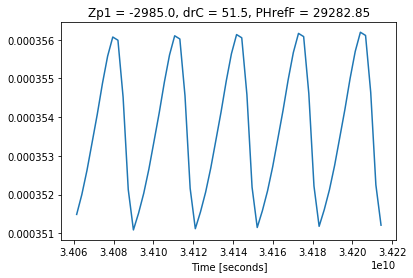

In [91]:
(dsave.PTRtave03*dsave.drF*np.abs(dsave.Zp1[-1])**-1).sum('Z').mean(['YC','XC']).plot()

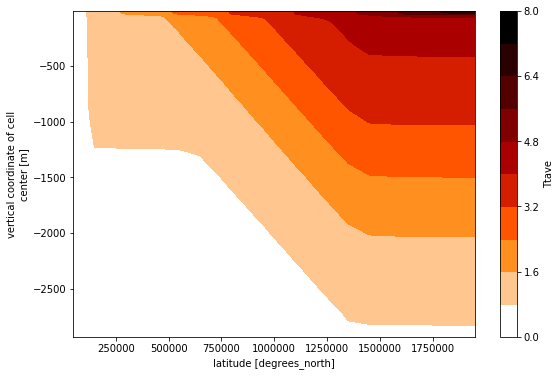

In [42]:
fig,ax = plt.subplots(figsize=(9,6))
# (dsave.PTRtave03.mean(['time','XC'])*1e3).plot.contourf(ax=ax, levels=np.linspace(0,.4,11),
#                                                         cmap='gist_heat_r')
dsave.Ttave[-120:].mean(['time','XC']).plot.contourf(ax=ax, levels=np.linspace(0,8,11),
                                                    cmap='gist_heat_r')

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


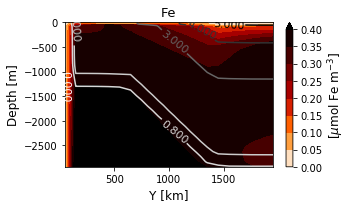

In [92]:
tlevs = np.array([0,.8,1,3,4,5])
fig, ax = plt.subplots(figsize=(5,3))
fig.set_tight_layout(True)
im = ax.contourf(dsave.YC*1e-3, dsave.Z, dsave.PTRtave03[-60:].mean(['time','XC'])*1e3,
               levels=np.linspace(0,.4,9), extend='max', cmap = 'gist_heat_r')
cs = ax.contour(dsave.YC*1e-3, dsave.Z, dsave.Ttave[-60:].mean(['time','XC']), 
              levels=tlevs, cmap='binary')
for c in im.collections:
    c.set_rasterized(True)
for c in cs.collections:
    c.set_rasterized(True)
ax.set_title(r"Fe", fontsize=13)
ax.set_ylabel(r"Depth [m]", fontsize=12)
ax.set_xlabel(r"Y [km]", fontsize=12)
ax.set_ylim([dsave.Z[-1],0])
plt.clabel(cs, inline=1, fontsize=11)
cb = fig.colorbar(im, ax=ax)
cb.set_label(r"[$\mu$mol Fe m$^{-3}$]",fontsize=12)
plt.savefig(op.join(bdir,'Figures/Fe-transect_100km-GM4000.pdf'))

In [100]:
dsave.coords['month'] = ('time',np.tile(range(12),dy))
Bdot = dsave.TFLUX
Bdot

<xarray.DataArray 'TFLUX' (time: 60, YC: 20, XC: 10)>
dask.array<shape=(60, 20, 10), dtype=float32, chunksize=(1, 20, 10)>
Coordinates:
  * XC       (XC) >f4 50000.0 150000.0 250000.0 ... 750000.0 850000.0 950000.0
  * YC       (YC) >f4 50000.0 150000.0 250000.0 ... 1850000.0 1950000.0
    rA       (YC, XC) >f4 dask.array<shape=(20, 10), chunksize=(20, 10)>
    Depth    (YC, XC) >f4 dask.array<shape=(20, 10), chunksize=(20, 10)>
    iter     (time) int64 dask.array<shape=(60,), chunksize=(1,)>
  * time     (time) float64 3.406e+10 3.406e+10 ... 3.421e+10 3.421e+10
    month    (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 ... 1 2 3 4 5 6 7 8 9 10 11
Attributes:
    standard_name:  TFLUX
    long_name:      total heat flux (match heat-content variations), >0 incre...
    units:          W/m^2

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/xarray/core/dataarray.py:2170: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs)


Text(0, 0.5, 'Y [km]')

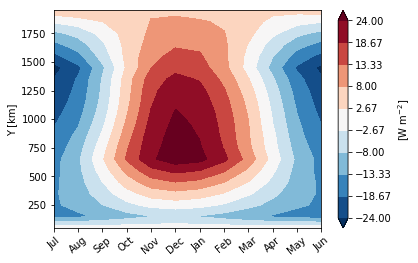

In [108]:
fig, ax = plt.subplots()
im = ax.contourf(range(12), Bdot.YC*1e-3,
                Bdot.groupby('month').mean(['time','XC']).roll(month=6).T, 
                cmap='RdBu_r', levels=np.linspace(-24,24,10), extend='both')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r"[W m$^{-2}$]")
ax.set_xticks(range(12))
ax.set_xticklabels(['Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun'],
                  rotation=40)
ax.set_ylabel(r"Y [km]")

In [43]:
Tave = dsave.Ttave[-120:].mean(['XC'])
with ProgressBar():
    hT = 2*((Tave.mean('time')*dsave.Z*dsave.drF).sum('Z')/(Tave.mean('time')*dsave.drF).sum('Z')).compute()
hT

[########################################] | 100% Completed |  0.3s


/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/dask/local.py:253: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


<xarray.DataArray (YC: 20)>
array([       nan, -2339.4868, -2325.3318, -2307.126 , -2254.3826, -2171.67  ,
       -2089.4858, -2024.7231, -1986.6829, -1974.162 , -1987.5664, -2020.6251,
       -2071.5234, -2130.434 , -2154.673 , -2151.2039, -2146.6646, -2142.95  ,
       -2140.0242, -2139.3054], dtype=float32)
Coordinates:
  * YC       (YC) >f4 50000.0 150000.0 250000.0 ... 1850000.0 1950000.0

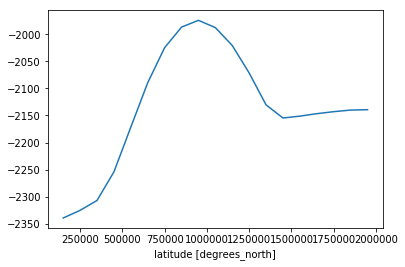

In [44]:
hT.plot()

In [45]:
Uave = dsave.uVeltave.mean(['XG'])
# Uanom = Uave - grid.interp(ug.mean('XC'), 'Y', boundary='fill')
# fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,8))
# Uave[-120:].mean('time').plot(ax=ax1, vmax=.5)
# Uanom[-120:].mean('time').plot(ax=ax2, vmax=.5)

In [46]:
uC = g*alpha * ((grid.diff(Tave * grid.interp(dsave.dxC,'X').mean('XC'),
                          'Y', boundary='fill')*dsave.rAs.mean('XC')**-1 * dsave.Z
                ).sum('Z') * dsave.dyC.mean('XC')).sum('YG') * f0**-1
uC

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/xarray/core/dataarray.py:2170: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs)


<xarray.DataArray (time: 120)>
dask.array<shape=(120,), dtype=float32, chunksize=(1,)>
Coordinates:
  * time     (time) float64 2.302e+10 2.302e+10 ... 2.333e+10 2.333e+10

In [31]:
with ProgressBar():
    uT = (Uave*dsave.drF*dsave.dyG.mean(['XG'])).sum(['Z','YC']).compute()
# with ProgressBar():
#     uC = (Uanom*dsave.drF*dsave.dyG.mean(['XG'])).sum(['Z','YC']).compute()
# uC

[########################################] | 100% Completed |  1min  0.5s


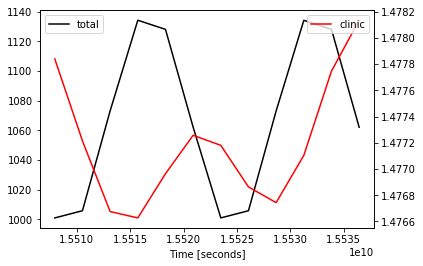

In [32]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
(uT[-18:-6]*1e-6).plot(ax=ax, c='k', label=r'total')
(uC[-18:-6]*1e-6).plot(ax=ax2, c='r', label=r'clinic')
ax2.legend(loc='upper right')
ax.legend(loc='upper left')
# ax2.set_yticks([1.852,1.854,1.856,1.858])
# ax2.set_yticklabels([1.852,1.854,1.856,1.858], color='r')

In [103]:
ds = open_mdsdataset(op.join(bdir,'100kmMLI_fmR1000diag'), 
                    grid_dir=op.join(bdir,'100km_grid'), 
                    iters=range(ts+18,te+18,18),
                    prefix=['MOMtave','FeTtave','BIOtave',
                           'KPPboundary'
                           ], delta_t=dt
                    )
ds

/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:   (XC: 10, XG: 10, YC: 20, YG: 20, Z: 40, Zl: 40, Zp1: 41, Zu: 40, time: 1800)
Coordinates:
  * XC        (XC) >f4 50000.0 150000.0 250000.0 350000.0 450000.0 550000.0 ...
  * YC        (YC) >f4 50000.0 150000.0 250000.0 350000.0 450000.0 550000.0 ...
  * XG        (XG) >f4 0.0 100000.0 200000.0 300000.0 400000.0 500000.0 ...
  * YG        (YG) >f4 0.0 100000.0 200000.0 300000.0 400000.0 500000.0 ...
  * Z         (Z) >f4 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 -126.0 ...
  * Zp1       (Zp1) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
  * Zu        (Zu) >f4 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
  * Zl        (Zl) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
    rA        (YC, XC) >f4 dask.array<shape=(20, 10), chunksize=(20, 10)>
    dxG       (YG, XC) >f4 dask.array<shape=(20, 10), chunksize=(20, 10)>
    dyG       (YC, XG) >f4 dask.array<shape=(20, 10), chunksize=(20, 10)>
    Depth     (YC, XC) >f4 

In [106]:
grid = Grid(ds, periodic=['X'])

In [113]:
hbl99 = xr.DataArray(np.percentile(ds.KPPhbl, 99, axis=-1), dims=['time','YC'],
                    coords={'time':ds.time,'YC':ds.YC})
hbl99.coords['day'] = ('time',np.tile(range(360),dy))
hbl99.coords['seas'] = ('time',np.tile(np.repeat(range(4),90),dy))
hbl99.coords['month'] = ('time',np.tile(np.repeat(range(12),30),dy))
hbl99.to_dataset(name='hbl99').to_netcdf(op.join(bdir,'KPPhbl_99percentile_100kmMLI-02km_fmR1000.nc'))
# hbl99 = xr.open_dataset(op.join(bdir,'KPPhbl_99percentile_20kmMLI-Ce007_Tau55-02km.nc'), 
#                         decode_times=False).hbl99
with ProgressBar():
    hbl99_day = hbl99.groupby('day').mean('time').compute()
# #     hbl99_sea = hbl99.groupby('seas').mean('time').compute()
# #     hbl99_mon = hbl99.groupby('month').mean('time').compute()
hbl99_day

<xarray.DataArray (day: 360, YC: 20)>
array([[   0. , 2933.5,   30. , ...,   30. ,   30. ,   30. ],
       [   0. , 2933.5,   30. , ...,   30. ,   30. ,   30. ],
       [   0. , 2933.5,   30. , ...,   30. ,   30. ,   30. ],
       ...,
       [   0. , 2933.5,   30. , ...,   30. ,   30. ,   30. ],
       [   0. , 2933.5,   30. , ...,   30. ,   30. ,   30. ],
       [   0. , 2933.5,   30. , ...,   30. ,   30. ,   30. ]])
Coordinates:
  * YC       (YC) >f4 50000.0 150000.0 250000.0 350000.0 450000.0 550000.0 ...
  * day      (day) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...

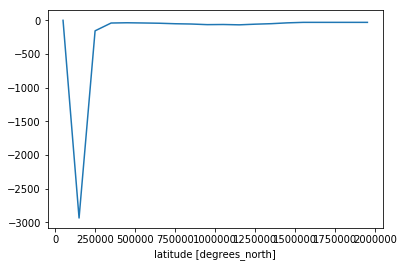

In [114]:
(-hbl99).mean(['time']).plot()

In [107]:
dsnap = open_mdsdataset(op.join(bdir,'100kmMLI_fmR1000diag'), 
                       grid_dir=op.join(bdir,'100km_grid'), iters=range(ts,te,270),
                       prefix=['W','PTRACER03',
#                               'PTRACER26'
                              ], delta_t=dt
                       )
dsmon = open_mdsdataset(op.join(bdir,'100kmMLI_fmR1000diag'), 
                       grid_dir=op.join(bdir,'100km_grid'), iters=range(ts+540,te+540,540),
                       prefix=['wVeltave','PTRtave03',
#                               'PTRtave26'
                              ], delta_t=dt
                       )
wsp = dsnap.W
Fesp = dsnap.PTRACER03
# POCsp = dsnap.PTRACER26
wm = dsmon.wVeltave
Fem = dsmon.PTRtave03
# POCm = dsmon.PTRtave26
print(wsp,wm)

/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.DataArray 'W' (time: 120, Zl: 40, YC: 20, XC: 10)>
dask.array<shape=(120, 40, 20, 10), dtype=float32, chunksize=(1, 40, 20, 10)>
Coordinates:
  * XC       (XC) >f4 50000.0 150000.0 250000.0 350000.0 450000.0 550000.0 ...
  * YC       (YC) >f4 50000.0 150000.0 250000.0 350000.0 450000.0 550000.0 ...
  * Zl       (Zl) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
    rA       (YC, XC) >f4 dask.array<shape=(20, 10), chunksize=(20, 10)>
    Depth    (YC, XC) >f4 dask.array<shape=(20, 10), chunksize=(20, 10)>
    iter     (time) int64 dask.array<shape=(120,), chunksize=(1,)>
  * time     (time) float64 1.026e+10 1.027e+10 1.027e+10 1.027e+10 ...
Attributes:
    standard_name:  sea_water_z_velocity
    long_name:      Vertical Component of Velocity
    units:          m s-1 <xarray.DataArray 'wVeltave' (time: 60, Zl: 40, YC: 20, XC: 10)>
dask.array<shape=(60, 40, 20, 10), dtype=float32, chunksize=(1, 40, 20, 10)>
Coordinates:
  * XC       (XC) >f4 50000.0 150000.0 2500

In [108]:
diff = ds.DFrITr03+ds.DFrETr03
advW = ds.ADVrTr03
dfz_cons = diff/(ds.rA)
adz_cons = advW/(ds.rA)
dfz_cons.coords['day'] = ('time',np.tile(range(360),dy))
adz_cons.coords['day'] = ('time',np.tile(range(360),dy))
wsp.coords['seas'] = ('time',np.tile(np.repeat(range(4),6),dy))
Fesp.coords['seas'] = ('time',np.tile(np.repeat(range(4),6),dy))
wm.coords['seas'] = ('time',np.tile(np.repeat(range(4),3),dy))
Fem.coords['seas'] = ('time',np.tile(np.repeat(range(4),3),dy))
# POCsp.coords['seas'] = ('time',np.tile(np.repeat(range(4),6),dy))
# POCm.coords['seas'] = ('time',np.tile(np.repeat(range(4),3),dy))
wp = wsp.groupby('seas') - wm.groupby('seas').mean(['time','XC'])
Fep = Fesp.groupby('seas') - Fem.groupby('seas').mean(['time','XC'])
# POCp = POCsp.groupby('seas') - POCm.groupby('seas').mean(['time','XC'])

In [109]:
wpFep = wp*grid.interp(Fep,'Z',boundary='fill')
wpFep.coords['day'] = ('time',np.tile(range(24),dy))
with ProgressBar():
    dfz_c = dfz_cons.sel(YC=slice(6e5,14e5)).groupby('day').mean(['time','YC','XC']).compute()
#     adz_c = adz_cons.sel(YC=slice(6e5,14e5)).groupby('day').mean(['time','YC','XC']).compute()
    wpFep_d = wpFep.sel(YC=slice(6e5,14e5)).groupby('day').mean(['time','YC','XC']).compute()

[########################################] | 100% Completed | 14.9s
[########################################] | 100% Completed |  3.0s


In [112]:
dsGM = open_mdsdataset(op.join(bdir,'100kmMLI_fmR1000diag'),
                      grid_dir=op.join(bdir,'100km_grid'), iters=range(ts,te,270),
                      prefix=['GMpsi15D',
                             ], delta_t=dt
                      )
dsGM

/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:  (XC: 10, XG: 10, YC: 20, YG: 20, Z: 40, Zl: 40, Zp1: 41, Zu: 40, time: 120)
Coordinates:
  * XC       (XC) >f4 50000.0 150000.0 250000.0 350000.0 450000.0 550000.0 ...
  * YC       (YC) >f4 50000.0 150000.0 250000.0 350000.0 450000.0 550000.0 ...
  * XG       (XG) >f4 0.0 100000.0 200000.0 300000.0 400000.0 500000.0 ...
  * YG       (YG) >f4 0.0 100000.0 200000.0 300000.0 400000.0 500000.0 ...
  * Z        (Z) >f4 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 -126.0 ...
  * Zp1      (Zp1) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
  * Zu       (Zu) >f4 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
  * Zl       (Zl) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
    rA       (YC, XC) >f4 dask.array<shape=(20, 10), chunksize=(20, 10)>
    dxG      (YG, XC) >f4 dask.array<shape=(20, 10), chunksize=(20, 10)>
    dyG      (YC, XG) >f4 dask.array<shape=(20, 10), chunksize=(20, 10)>
    Depth    (YC, XC) >f4 dask.array<sha

In [115]:
gridGM = Grid(dsGM, periodic=['X'])
Psiyk = xrft.dft(dsGM.GM_PsiY, dim=['XC'], shift=False)
Psiy_x = dsar.fft.ifft((Psiyk*1j*2*np.pi*Psiyk.freq_XC).data, axis=-1).compute()
Psiy_x = gridGM.interp(xr.DataArray(Psiy_x.real, dims=dsGM.GM_PsiY.dims, coords=dsGM.GM_PsiY.coords),
                      'Y', boundary='fill')
with ProgressBar():
    wGM = (Psiy_x - gridGM.interp(gridGM.interp(gridGM.diff(dsGM.GM_PsiX*dsGM.dxC,'Y',boundary='fill')
                                               / dsGM.rAz,
                                               'Y',boundary='fill'),
                                 'X')
          ).compute()
wGM

/home/takaya/xrft/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  4.7s


<xarray.DataArray (time: 120, Zl: 40, YC: 20, XC: 10)>
array([[[[ 0.000000e+00, ...,  0.000000e+00],
         ...,
         [ 0.000000e+00, ...,  0.000000e+00]],

        ...,

        [[ 0.000000e+00, ...,  0.000000e+00],
         ...,
         [-1.537683e-22, ...,  1.625427e-22]]],


       ...,


       [[[ 0.000000e+00, ...,  0.000000e+00],
         ...,
         [ 0.000000e+00, ...,  0.000000e+00]],

        ...,

        [[ 0.000000e+00, ...,  0.000000e+00],
         ...,
         [-1.566334e-22, ...,  1.605094e-22]]]])
Coordinates:
  * time     (time) float64 1.026e+10 1.027e+10 1.027e+10 1.027e+10 ...
  * Zl       (Zl) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
  * YC       (YC) >f4 50000.0 150000.0 250000.0 350000.0 450000.0 550000.0 ...
  * XC       (XC) >f4 50000.0 150000.0 250000.0 350000.0 450000.0 550000.0 ...

In [118]:
wGMFe_adv = wGM*grid.interp(Fesp,'Z',boundary='fill')
wGMFe_adv.coords['day'] = ('time',np.tile(range(24),dy))
with ProgressBar():
    wGMFe_advd = wGMFe_adv.sel(YC=slice(6e5,14e5)).groupby('day').mean(['time','YC','XC']).compute()
wGMFe_advd

[########################################] | 100% Completed |  2.0s


<xarray.DataArray (day: 24, Zl: 40)>
array([[ 0.000000e+00,  3.269743e-28,  3.557881e-28, ...,  5.246065e-32,
        -1.472229e-30,  3.895495e-29],
       [ 0.000000e+00,  2.457812e-28,  2.683803e-28, ...,  7.327837e-32,
        -1.543009e-30,  3.985594e-29],
       [ 0.000000e+00,  1.989412e-28,  2.161544e-28, ..., -6.983207e-23,
        -3.256840e-23,  4.013157e-29],
       ...,
       [ 0.000000e+00, -2.587591e-28, -2.113350e-28, ...,  7.910733e-32,
        -1.101674e-30,  3.534682e-29],
       [ 0.000000e+00,  1.039500e-28,  1.131621e-28, ..., -1.240878e-22,
        -1.218253e-30,  3.630360e-29],
       [ 0.000000e+00,  3.650989e-28,  3.954498e-28, ...,  4.996253e-32,
         5.707681e-22,  3.760013e-29]])
Coordinates:
  * Zl       (Zl) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
  * day      (day) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...

In [120]:
Fe1D = ds.TRAC03
Fe1D.coords['day'] = ('time',np.tile(np.roll(range(360),0),dy))
with ProgressBar():
    Fe_c = Fe1D.sel(YC=slice(6e5,14e5)).groupby('day').mean(['time','YC','XC']).compute()
Fe_c

[########################################] | 100% Completed | 13.7s


<xarray.DataArray 'TRAC03' (day: 360, Z: 40)>
array([[3.429686e-06, 3.402950e-06, 3.380198e-06, ..., 2.393328e-04,
        2.404354e-04, 2.414382e-04],
       [3.535343e-06, 3.508910e-06, 3.486158e-06, ..., 2.393319e-04,
        2.404361e-04, 2.414429e-04],
       [3.643385e-06, 3.617279e-06, 3.594594e-06, ..., 2.393311e-04,
        2.404369e-04, 2.414477e-04],
       ...,
       [3.128503e-06, 3.100509e-06, 3.077802e-06, ..., 2.389915e-04,
        2.400879e-04, 2.410772e-04],
       [3.224618e-06, 3.197052e-06, 3.174221e-06, ..., 2.389905e-04,
        2.400884e-04, 2.410816e-04],
       [3.324016e-06, 3.296863e-06, 3.274007e-06, ..., 2.389896e-04,
        2.400889e-04, 2.410862e-04]], dtype=float32)
Coordinates:
  * Z        (Z) >f4 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 -126.0 ...
    drF      (Z) >f4 10.0 10.0 10.0 12.0 14.0 16.0 19.0 22.0 26.0 30.0 36.0 ...
    PHrefC   (Z) >f4 49.05 147.15 245.25 353.16 480.69 627.84 799.515 ...
  * day      (day) int64 0 1 2 3 4 5 6 7 8 

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


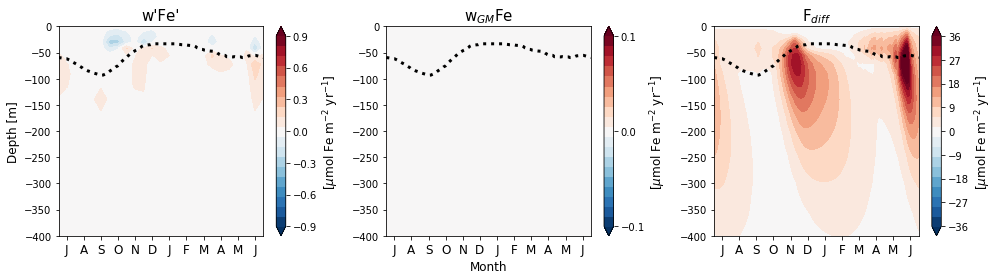

In [122]:
month = ['J','F','M','A','M','J','J','A','S','O','N','D']

fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14,4))
fig.set_tight_layout(True)
im1 = ax1.contourf(range(0,346,15), wpFep_d.Zl, wpFep_d.roll(day=-12).T*1e3*360*86400, 
                  levels=np.linspace(-.9,.9,20), 
                   cmap='RdBu_r', extend='both')
ax1.contourf(range(14,360,15), wpFep_d.Zl, wpFep_d.roll(day=-13).T*1e3*360*86400, 
            levels=np.linspace(-.9,.9,20), 
             cmap='RdBu_r', extend='both')
im2 = ax2.contourf(range(0,346,15), wGMFe_advd.Zl, wGMFe_advd.roll(day=-12).T*1e3*360*86400,
                  levels=1e-0*np.linspace(-.1,.1,20), 
                  extend='both', cmap='RdBu_r')
ax2.contourf(range(14,360,15), wGMFe_advd.Zl, wGMFe_advd.roll(day=-13).T*1e3*360*86400,
            levels=1e-0*np.linspace(-.1,.1,20), 
            extend='both', cmap='RdBu_r')
# im3 = ax3.contourf(range(360), Fe_c.Z, Fe_c.roll(day=-180).T*1e3, 
#                   levels=np.linspace(0,.3,11), cmap='OrRd', extend='max')
im3 = ax3.contourf(range(360), dfz_c.Zl, dfz_c.T.roll(day=-180)*1e3*(360*86400), 
                  levels=np.linspace(-36,36,20), 
                  cmap='RdBu_r', extend='both')
ax1.plot(range(360), -hbl99_day.sel(YC=slice(6e5,14e5)).mean(['YC']).roll(day=-180), 
       ls=':', lw=3, color='k')
ax2.plot(range(360), -hbl99_day.sel(YC=slice(6e5,14e5)).mean(['YC']).roll(day=-180), 
       ls=':', lw=3, color='k')
ax3.plot(range(360), -hbl99_day.sel(YC=slice(6e5,14e5)).mean(['YC']).roll(day=-180), 
       ls=':', lw=3, color='k')
ax1.set_title(r"w'Fe'", fontsize=15)
ax2.set_title(r"w$_{GM}$Fe", fontsize=15)
ax3.set_title(r"F$_{diff}$", fontsize=15)
ax1.set_ylabel(r"Depth [m]", fontsize=12)
ax2.set_xlabel(r"Month", fontsize=12)
ax1.set_xticks(np.linspace(14,344,12))
ax1.set_xticklabels(np.roll(np.array(month),-6), fontsize=12)
ax1.set_ylim([-400,0])
ax2.set_xticks(np.linspace(14,344,12))
ax2.set_xticklabels(np.roll(np.array(month),-6), fontsize=12)
ax2.set_ylim([-400,0])
ax3.set_xticks(np.linspace(14,344,12))
ax3.set_xticklabels(np.roll(np.array(month),-6), fontsize=12)
ax3.set_ylim([-400,0])
# fig.colorbar(im1, ax=ax1, ticks=[-10,-7.5,-5.,-2.5,0,2.5,5.,7.5,10])
# fig.colorbar(im2, ax=ax2, ticks=[-.8,-.6,-.4,-.2,0,.2,.4,.6,.8])
# cbar = fig.colorbar(im3, ax=ax3, ticks=[0,6,12,18,24,30])
# fig.subplots_adjust(right=0.85)
# cbar_ax = fig.add_axes([0.88, 0.16, 0.014, 0.68])
# cbar = fig.colorbar(im3, cax=cbar_ax, ticks=[-10,-8,-6,-4,-2,0,2,4,6,8,10])
# cbar.set_label(r'[$\mu$mol Fe m$^{-2}$ yr$^{-1}$]', fontsize=12)
cbar1 = fig.colorbar(im1, ax=ax1, 
                    ticks=[-.9,-.6,-.3,0,.3,.6,.9]
                    )
cbar2 = fig.colorbar(im2, ax=ax2, 
                    ticks=[-.1,-.75,-.5,-.25,0,.25,.5,.75,.1]
                    )
cbar3 = fig.colorbar(im3, ax=ax3, 
                    ticks=[-36,-27,-18,-9,0,9,18,27,36]
                    )
cbar1.set_label(r"[$\mu$mol Fe m$^{-2}$ yr$^{-1}$]", fontsize=12)
cbar2.set_label(r"[$\mu$mol Fe m$^{-2}$ yr$^{-1}$]", fontsize=12)
cbar3.set_label(r"[$\mu$mol Fe m$^{-2}$ yr$^{-1}$]", fontsize=12)
# plt.savefig(op.join(bdir,'Figures/VerticalFeflux_20kmMLI-02km_fm200.pdf'))